# Checking the SEO Test Setup

I.e. checking that the right urls are set up, without going too crazy on testing everything.

In brief:

* Focus on the articles
* Check the test urls are accessible and show v2
* If AMP is enabled, test that control urls show v1 AMP and test urls show v2
* Check the canonicals
* Check the breadcrumbs
* That cloudflare looks to be working


Out of scope:

* That an AMP page is valid AMP (we have a separate test suite for this)
* Being robust to html that isn't what's expected during blog v2 launch!
* Testing non-article pages (home page, category page etc)

In [1]:
import requests
from datetime import datetime
from bs4 import BeautifulSoup
import csv
import json
import urllib
import json
import time
import matplotlib.pyplot as plt
from random import random, randint
import numpy as np

## Settings


In [2]:
country_to_test = "sg"
test_staging = True

test_urls_csv_filepath = {  # These originally come from https://docs.google.com/spreadsheets/d/1UdrncwVdObaA6d0lnvbAQCHBpQMzEhWPz5OTR9Syobo/edit#gid=0
    "id":"./SEO Test Urls/id_seo_test_urls.csv",
    "tw":"./SEO Test Urls/tw_seo_test_urls.csv",
    "sg": "./SEO Test Urls/sg_seo_test_urls.csv",
    "hk": "./SEO Test Urls/hk_seo_test_urls.csv",
}

production_staging_urls = {
    "id": ["https://www.moneysmart.id", "https://www.msiddev.com"],
    "tw":["https://www.moneysmart.tw", "https://www.mstwdev.com"],
    "sg": ["https://blog.moneysmart.sg","https://blog.mssgdev.com"],
    "hk":["https://www.moneysmart.hk", "https://blog.mshkdev.com"],
}

def get_site_canonical_url():
    
    return production_staging_urls[country_to_test][(1 if test_staging else 0)]

post_sitemaps = { #yes, we could load some more dynamically but it saves some coding
    "id": ["https://www.moneysmart.id/post-sitemap%i.xml"%i for i in range(1,13)],
    "tw": ["https://www.moneysmart.tw/post-sitemap.xml"],
    "sg": ["https://blog.moneysmart.sg/post-sitemap%i.xml"%i for i in range(1,5)],
    "hk": ["https://blog.moneysmart.hk/post-sitemap%i.xml"%i for i in range(1,3)],
    
    #Aside, there seems to be public pages for the ads in the sitemap :( 
    
}

# RSS feed requests are taken from scalyr by setting display to show uri, remote_ip, status
# e.g. https://www.scalyr.com/events?filter=%22%2Ffeed%2F%22%20$status%3D200&teamToken=RsXhT5US%2FMZ7ugkOhT2g3g--&logSource=*blog-moneysmart-sg-*&showSystemPrefs=%5B%22timestamp%22%5D&showAdditionalFields=%5B%22uri%22,%22remote_ip%22,%22status%22%5D&startTime=7%20days&displayMode=%5Bobject%20Object%5D
rss_feed_scalyr_requests_raw = {
    "id":"./RSS Feed Urls/id_scalyr_feed_requests_tidy.txt",
    "tw":"./RSS Feed Urls/tw_scalyr_feed_requests_tidy.txt",
    "sg": "./RSS Feed Urls/sg_scalyr_feed_requests_tidy.txt",
    "hk": "./RSS Feed Urls/hk_scalyr_feed_requests_tidy.txt",
    
}


#Redirects

#These are taken from Yoast.  You can go to yoast-> tools -> import and export to get a CSV of redirects.
#https://admin.mstwdev.com/wp-admin/admin.php?page=wpseo_tools&tool=import-export#top#export-redirects
#You could do a database query to a copy of production in future.

staging_redirects_csvs = {
    "id":"./Redirects/id-staging-redirects.csv",
    "tw":"./Redirects/tw-staging-redirects.csv",
    "sg":"./Redirects/sg-staging-redirects.csv",
    "hk":"./Redirects/hk-staging-redirects.csv",
    
}

production_redirects_csvs = {
    "id":"./Redirects/id-production-redirects.csv",
    "tw":"./Redirects/tw-production-redirects.csv",
    "sg":"./Redirects/sg-production-redirects.csv",
    "hk": "./Redirects/hk-production-redirects.csv",
    
}

#These passwords aren't sensitive, they're just there to block search engine.
v1_staging_passwords = {
    "id":["admin", "moneysmart"],
    "tw":["admin", "Bubbl3"],
    "sg":["admin", "duri@n"],
    "hk":["admin", "yu3ch@"],
}

v2_staging_passwords = {
    "id":["admin", "moneysmart"],
    "tw":["admin", "moneysmart"],
    "sg":["admin", "moneysmart"],
    "hk":["admin", "moneysmart"],
}

amp_is_enabled = {
    "id":True,
    "tw":False,
    "sg":False,
    "hk":False,
    
}

## Test URL Sets

In [3]:
def load_seo_test_urls(country_code):
    filepath = test_urls_csv_filepath[country_code]
    urls = []
    with open(filepath) as f:
        csv_reader = csv.reader(f, delimiter=',')
        for i, row in enumerate(csv_reader):
            if i==0:
                print("Skipping first line of url file: %s"%row)
                continue
            urls.append(row[0].strip())

    return urls

seo_test_urls = load_seo_test_urls(country_to_test)

print("Found %i test urls to check for" % len(seo_test_urls))


Skipping first line of url file: ['url']
Found 50 test urls to check for


In [4]:
for a in seo_test_urls:print(a)

https://blog.moneysmart.sg/entertainment/cheap-ktv-singapore-top-picks/
https://blog.moneysmart.sg/dining/holland-village-food-price-guide/
https://blog.moneysmart.sg/shopping/carousell-lazada-qoo10-shopee-seller/
https://blog.moneysmart.sg/healthcare/cheap-dentists-singapore-dental-clinics/
https://blog.moneysmart.sg/education/singapore-university-education-cost/
https://blog.moneysmart.sg/shopping/amazon-prime-singapore/
https://blog.moneysmart.sg/budgeting/iphone-xs-xr-price-singapore/
https://blog.moneysmart.sg/budgeting/hair-salon-singapore-guide/
https://blog.moneysmart.sg/travel/multi-currency-accounts-youtrip/
https://blog.moneysmart.sg/healthcare/health-screening-singapore-cost/
https://blog.moneysmart.sg/healthcare/acne-treatment-singapore-cost/
https://blog.moneysmart.sg/budgeting/gst-voucher-u-save/
https://blog.moneysmart.sg/property/rent-singapore-cost-guide/
https://blog.moneysmart.sg/dining/bubble-tea-price-koi-liho-gongcha-taigai/
https://blog.moneysmart.sg/invest/inve

## Check SEO Test URLs aren't Redirects

Redirects implies that we won't be able to get sensible results from search console as they should have dropped off already to the redirected-to url.

In [5]:
def load_redirects(country_code, for_staging, unencode_urls = False):
    """
    Returns [from_url, to_url, redirect_code]
    Where from_url is the full url (and the source CSV doesn't state as full url)
    
    Use unencode_urls for TW and HK
    """
    print("cow")
    base_url = production_staging_urls[country_code][1 if for_staging else 0]
    redirects_csv_path = None
    if for_staging:
        redirects_csv_path = staging_redirects_csvs[country_code]
    else:
        redirects_csv_path = production_redirects_csvs[country_code]

    print("Loading all of the redirects from %s" % redirects_csv_path)

    redirects = [] #from, to, code
    with open(redirects_csv_path) as f: #Origin,Target,Type,Format
        csv_reader = csv.reader(f, delimiter=',')
        for i, row in enumerate(csv_reader):
            if i==0:
                print("Skipping first line of url file: %s"%row)
                continue
            from_url, to_url, redirect_code, redirect_format = row
            if unencode_urls:
                #TODO: not sure how safe this is unquoting, but doing to try to match TW urls.
                from_url = urllib.parse.unquote(from_url)
                to_url = urllib.parse.unquote(to_url)
            from_url_full = urllib.parse.urljoin(base_url, from_url)+"/"
            to_url_full = urllib.parse.urljoin(base_url, to_url)+"/"
            redirects.append([from_url_full, to_url_full, redirect_code])

    print("Loaded %i redirects"% len(redirects))
    return redirects

In [6]:
# Get the production redirects as at this point we're testing the production urls 
# (there might be a mismatch with staging, but this is the safest test)

production_redirects = load_redirects(country_to_test, for_staging=False, unencode_urls = True)

cow
Loading all of the redirects from ./Redirects/sg-production-redirects.csv
Skipping first line of url file: ['Origin', 'Target', 'Type', 'Format']
Loaded 1019 redirects


In [7]:
production_redirected_urls = [z[0] for z in production_redirects]
seo_test_urls_that_are_redirects = [z for z in seo_test_urls if z in production_redirected_urls]

In [8]:
# Check the below two blocks look similar / the urls are likely to match

In [9]:
production_redirected_urls[:5]

['https://blog.moneysmart.sg/entertainment/5-valentines-day-ideas-singaporeans-can-consider-for-under-60/',
 'https://blog.moneysmart.sg/travel/5-inexpensive-southeast-asian-destinations-visit-2018/',
 'https://blog.moneysmart.sg/transportation/cheapest-parking-in-orchard-road/',
 'https://blog.moneysmart.sg/property/property-agents-how-to-find-the-right-one/',
 'https://blog.moneysmart.sg/invest/the-best-investment-is-a-house/']

In [10]:
seo_test_urls[:5]

['https://blog.moneysmart.sg/entertainment/cheap-ktv-singapore-top-picks/',
 'https://blog.moneysmart.sg/dining/holland-village-food-price-guide/',
 'https://blog.moneysmart.sg/shopping/carousell-lazada-qoo10-shopee-seller/',
 'https://blog.moneysmart.sg/healthcare/cheap-dentists-singapore-dental-clinics/',
 'https://blog.moneysmart.sg/education/singapore-university-education-cost/']

In [11]:
if len(seo_test_urls_that_are_redirects)>0:
    print("The following SEO test urls were redirects.  We should remove them from the test:")
    for a in seo_test_urls_that_are_redirects:
        print(a)
    
else:
    print("Looks like none of the SEO test urls are redirects, which is good.")

Looks like none of the SEO test urls are redirects, which is good.


## Utility Functions

In [12]:
def get_urls_from_sitemap(sitemap_url, page_cache):
    
    #r = requests.get(sitemap_url)
    #soup = BeautifulSoup(r.text, "html.parser") #html parser does xml fine
    soup = page_cache.get_soup(sitemap_url)
    urls = [element.text for element in soup.findAll('loc')]
    return urls

def get_all_post_urls_from_sitemap(country_code, page_cache):
    # Note that separately I'm loading all the sitemaps, so you could use that instead if you can filter the posts.
    sitemaps = post_sitemaps[country_code]
    all_urls = []
    for i, sitemap in enumerate(sitemaps):
        print("Loading urls from sitemap %i of %i %s" % (i, len(sitemaps), sitemap))
        sitemap_urls = get_urls_from_sitemap(sitemap, page_cache)
        all_urls+=sitemap_urls
    return all_urls



In [13]:
def extract_sub_sitemaps_from_sitemap(sitemap_url, page_cache, recursive = False):
    root_sitemap_soup = page_cache.get_soup(sitemap_url)
    sub_sitemaps = []
    for sitemap_block in root_sitemap_soup.find_all("sitemap"):
        sub_sitemap_url = sitemap_block.loc.text
        sub_sitemaps.append(sub_sitemap_url)
        if recursive:
            next_levels =  extract_sub_sitemaps_from_sitemap(sub_sitemap_url, page_cache, recursive = True)
            sub_sitemaps+=next_levels
    return sub_sitemaps

In [14]:
def is_v2_url(url):
    splits = urllib.parse.urlparse(url)
    if "www3." in splits.netloc or "blog3." in splits.netloc:
        return True
    return False

def is_v1_url(url):
    return not is_v2_url(url)

    
def make_staging_url(url):
    # not responsible for auth
    production_root, staging_root = production_staging_urls[country_to_test]
    if production_root not in url:
        raise Exception()
        
    staging_url = url.replace(production_root, staging_root)
    
    return staging_url
    
    
def force_url_to_v1(url):
    return url+"?forceTest=control"
    
def force_url_to_v2(url):
    url_start, url_rest = url.split(".", 1)
    if url_start == "https://www":
        new_url = "https://www3."+url_rest
    elif url_start == "https://blog":
        new_url = "https://blog3."+url_rest
    else:
        new_url = url_start + "."+ url_rest
    return new_url+"?forceTest=test"
                                   

def is_amp_page(url, page_cache):
    """
    Very basic test on whether the page is marked in the html tag as AMP
    
       # <html ⚡> or <html amp>
    rab"""
    soup = page_cache.get_soup(url)
    html_tag = soup.find('html')
    html_tag.attrs
    
    if "amp" in html_tag.attrs or "⚡" in html_tag.attrs:
        return True
    return False
    
    
 
    
def is_v2_page(url, page_cache):
    """
    Very basic test if it's a v2 page based on knowledge of it.
    """
    html = page_cache.get_html(url)
    if "nuxt" in html:
        return True
    return False
    
    
def is_v2_amp_page(url, page_cache):
    if is_v2_page(url, page_cache) and is_amp_page(url, page_cache):
        return True
    return False
    
def extract_link_of_type(url, page_cache, type_of_link):
    """
    Generally don't call this directly.
    
    Expects it to be unique in the page / no duplicates
    """
    
    soup = page_cache.get_soup(url)
    links = soup.find_all("link")
    suitable_link_tags = [z for z in links if "rel" in z.attrs and z.attrs["rel"][0].lower()==type_of_link.lower()]
    if len(suitable_link_tags)==0:
        return None
    if len(suitable_link_tags)>1:
        raise Exception()
    
    link_url = suitable_link_tags[0].get("href")
    
    return link_url
    
    
    
    
    
def extract_link_to_amp_version(url, page_cache):
    """
    Returns none if the amp version can't be found
    
    Looking for <link rel="amphtml" href="..."
    
    Returns the url it links to
    """
    amp_url = extract_link_of_type(url, page_cache, "amphtml")
    
    return amp_url

def amp_and_canonical_urls_match(amp_url, canonical_url):
    if amp_url == canonical_url+"?amp": # better would be to do a join using url library
        return True
    return False
    
    

    
    
def extract_canonical_tag(url, page_cache):
    """
    
    Looks for <link rel="canonical" href="....">
    
    This is similar to amphtml
    """
    canonical_url = extract_link_of_type(url, page_cache, "canonical")
    return canonical_url

    
def canonical_tag_is_valid(url, canonical_url):
    """
    Returns bool, error_message
    
    """
    url_components = urllib.parse.urlparse(url)
    canonical_components = urllib.parse.urlparse(canonical_url)
    
    error_message = ""
    
    
    #Canonical uses https
    if canonical_components.scheme != "https":
        error_message += "Canonical does't use https. "
    
    # no query params in canonical
    if canonical_components.query:
        error_message += "Canonical url contains query parameters. "
    
    
    # goes to base url
    expected_root_url = get_site_canonical_url()
    if not canonical_url.startswith(expected_root_url):
        error_message += "Canonical url doesn't appear to point to right site."
    
    
    # url and canonical point to the same article
    if url_components.path != canonical_components.path:
        error_message += "Canonical and url don't point to same url. "
    
    
    return error_message=="", error_message
    
def extract_meta_description(url, page_cache):
    """
    <meta name="description" content="Jika kamu...">
    
    """
    print("getting meta description for %s"%url)
    soup = page_cache.get_soup(url)

    
    meta_tags = soup.find_all("meta")
    meta_tag_name = "description"
    
    suitable_tags = [z for z in meta_tags if "name" in z.attrs and z.attrs["name"].lower()==meta_tag_name.lower()]
    if len(suitable_tags)==0:
        return None
    if len(suitable_tags)>1:
        raise Exception()
    
    #print("suitable tag %s"%suitable_tags[0])
    meta_description = suitable_tags[0].get("content")
    return meta_description
    
    
def extract_ld_json_structured_data(url, page_cache, type_of_structured_data):
    """
    Returns as parsed JSON i.e. should be able to inspect as a dictionary etc.
    """
    
    #Note there's lots of valid ways of doing this, I'm just trying to match the way it's been implemented
    
    soup = page_cache.get_soup(url)
    
    script_tags = soup.find_all("script")
    sd_tags = [z for z in script_tags if "type" in z.attrs and z.attrs["type"]=="application/ld+json"]
    #print(sd_tags)
    json_structured_datas = [json.loads(z.contents[0]) for z in sd_tags]
    structured_datas_of_type = [z for z in json_structured_datas if z["@type"]==type_of_structured_data]
    if len(structured_datas_of_type) > 1:
        raise Exception()
    if len(structured_datas_of_type) == 0:
        raise Exception() # just for debugging
        return None
    return structured_datas_of_type[0]
    
def extract_blogposting_structured_data(url, page_cache):
    sd = extract_ld_json_structured_data(url, page_cache, "BlogPosting")
    return sd


def check_blogposting_structured_data_looks_sensible(url, page_cache):
    """
    returns [bool, error_message]
    """
    error_message = ""
    sd = extract_blogposting_structured_data(url, page_cache)
    
    
    expected_top_level_keys = ["@type", 
                               "headline", 
                               "datePublished", 
                               "dateModified",
                               "mainEntityOfPage",
                               "image",
                               "author",
                               "publisher",
                              ]
    missing_top_level_keys = [z for z in expected_top_level_keys if z not in sd]
    if len(missing_top_level_keys)>0:
        error_message += "BlogPosting was missing the following keys: %s .  "%missing_top_level_keys
    
    page_meta_description = extract_meta_description(url, page_cache)
    bp_description = sd["description"]
    if bp_description != page_meta_description:
        error_message+="Page meta description doesn't match blogposting description.  \n %s \n vs \n %s"%(page_meta_description,bp_description)
        
    #TODO: check headline
    
    logo_details = sd["publisher"]["logo"]
    logo_width = int(logo_details["width"])
    logo_height = int(logo_details["height"])
    
    expected_logo_width = 447
    expected_logo_height = 60
    
    if logo_width != expected_logo_width or logo_height!=expected_logo_height:
        error_message+="Logo size in structured data was (%i, %i) not (%i, %i).  "%(logo_width, logo_height, expected_logo_width, expected_logo_height)
    
    bp_id = sd["mainEntityOfPage"]["@id"]
    canonical_url = extract_canonical_tag(url, page_cache)
    if bp_id != canonical_url:
        error_message+="Expected the ID of the blogposting to be the canonical tag %s, but got %s.  "% (canonical_url,bp_id)
        
    return (len(error_message)==0, error_message)
        
    
    
def extract_breadcrumbs_as_list(url, page_cache):
    """
    Returns [[name, url]]
    
        {
    "@context": "https://schema.org",
    "@type": "BreadcrumbList",
      "itemListElement": [{
        "@type": "ListItem",
        "position": 1,
        "name": "Books",
        "item": "https://example.com/books"
      },
      ...
      }
    
    """
    sd = extract_ld_json_structured_data(url, page_cache, "BreadcrumbList")
    
    breadcrumbs = [[z["position"], z["item"]["name"], z["item"]["@id"]] \
                   for z in sd["itemListElement"]\
                      if z["@type"]=="ListItem"
                  ]
    breadcrumbs.sort(key=lambda x: x[0]) #sort by position
    
    
    return [z[1:] for z in breadcrumbs]


def check_breadcrumbs_are_sensible(url, page_cache):
    """
    Return (is_ok, error_message)
    """
    # TODO: ideally would add some more checks on the validity of the structured data, but they can be done
    # fairly easily with external tools.
    
    error_message = ""
    breadcrumbs = extract_breadcrumbs_as_list(url, page_cache)
    breadcrumb_names = [z[0] for z in breadcrumbs]
    breadcrumb_urls = [z[1] for z in breadcrumbs]
    
    expected_url_root = get_site_canonical_url()
    
    
    breadcrumbs_not_starting_with_root = [z for z in breadcrumb_urls if not z.startswith(expected_url_root)]
    
    if len(breadcrumbs_not_starting_with_root):
        error_message+= "Breadcrumbs didn't all start with the right url base (%s) %s . "%(expected_url_root, breadcrumbs_not_starting_with_root)
    
    if breadcrumb_urls[0].strip("/")!=expected_url_root:
        error_message += "Expected 1st breadcrumb to be homepage %s, but got %s.  "%(expected_url_root, breadcrumb_urls[0])
    
    num_unique_urls =  len(set(breadcrumb_urls))
    if num_unique_urls != len(breadcrumb_urls):
        error_message += "Breadcrumbs weren't unique.  Got %s .  "%breadcrumb_urls
    
    #Check there's at least 3 (homepage, category, article)
    
    failing_category_urls = [z for z in breadcrumb_urls[1:-1] if "/category/" not in z]
    if len(failing_category_urls)>0:
        error_message += "Category breadcrumbs don't look like category pages %s.  "%failing_category_urls
    
    if len(breadcrumbs)<3:
        error_message+="Expected at least homepage, category and article in breadcrumbs, but got %s.   "%breadcrumbs
    
    return (len(error_message)==0, error_message)
    
    
    



In [15]:
class PageCache(object):
    """
    This is an abstraction for getting a url, which understands
    translation between staging and production, authentication etc
    and uses a cache to allow efficient repeat requests.
    (and whether that cache is in memory, or not is academic)
    
    It also includes throttling.
    
    The result might be a redirect to say www3 or whatever.
    
    NB this does currently rely on some globals
    """
    
    def __init__(self):
        self._page_cache_dict = {} #url:[page_html, load_time, cloudflare_in_headers, cloudflare_hit, url_after_redirect]
        self._soup_cache_dict = {} #url: beautifulsoup
        self._page_load_time_dict = {} # a log of how long it takes to load the pages in seconds
        self.last_page_respone_time  = datetime.now()
        self.min_seconds_between_server_requests = 0.5 #currently after request completion, rather than start
    
    def get_html(self, url, refresh_cache = False):
        """
        This gets the url, but only requests it if it isn't in the page cache currently
        """
        if refresh_cache or url not in self._page_cache_dict:
            seconds_since_last_request = (datetime.now() - self.last_page_respone_time).total_seconds()
            wait_time = self.min_seconds_between_server_requests - seconds_since_last_request
            if wait_time>0:
                print("Throttling request for %.2f seconds"%wait_time)
                time.sleep(wait_time)
            
            self._download_url_and_cache(url) # this also does things like check caching and do timing.
            
        html = self._page_cache_dict[url][0]
        
        self.last_page_request_time = datetime.now()
        
        return html
        
    def get_soup(self, url):
        """
        Returns the beautifulsoup version of the page for tag extraction
        """
        if url not in self._soup_cache_dict:
            html = self.get_html(url)
            soup = BeautifulSoup(html, "html.parser")
            self._soup_cache_dict[url] = soup

        return self._soup_cache_dict[url]
        

        
    def _download_url_and_cache(self, url):
        user_pass = None
        
        
        if test_staging:
            #Need to deal with basic auth
            # TODO
            if is_v1_url(url):
                user_pass = v1_staging_passwords[country_to_test]
            else:
                user_pass = v2_staging_passwords[country_to_test]
            user_pass = tuple(user_pass) #required to make the requests library happy
        
        r = requests.get(url, auth= user_pass)
        
        if r.status_code == 401:
            
            #print("Got a 401 on %s with credentials %s" % (url, user_pass))
            if test_staging:
                # print("Going to try again with other creds as likely redirect with different creds.")
                if not is_v1_url(url): # flipping counter-intuitively
                    user_pass = v1_staging_passwords[country_to_test]
                else:
                    user_pass = v2_staging_passwords[country_to_test]
                # print("Trying with creds %s"%user_pass)
                r = requests.get(url, auth=tuple(user_pass))
                if r.status_code == "401":
                    print("failed with other auth after trying two credentials")
                    raise Exception()
            else:
                raise Exception()
        elif r.status_code!=200:
            print("WARNING: STATUS CODE %s on %s" % (str(r.status_code), url))
        
        r.raise_for_status() #Throw an exception if get e.g. a 404.
        
        load_time = r.elapsed.total_seconds()
        text = r.text
        headers = r.headers
        
        # Look at headers to judge if caching on the html is working
        is_cdn_caching = False
        is_cdn_cache_hit = False
        if "Server" in headers:
            if headers["Server"]=="cloudflare":
                is_cdn_caching = True
                if headers["cf-cache-status"]=="HIT":
                    is_cdn_cache_hit = True
            

        url_after_redirect = r.url
        #"cf-cache-status" "HIT"  /"EXPIRED"
        #"server:cloudflare"
        
        self._page_cache_dict[url] = text, load_time, is_cdn_caching, is_cdn_cache_hit, url_after_redirect
        
    def page_was_cdn_cached_and_hit(self, url):
        """
        Returns true if the last request to that url was cached.
        """
        pc = self._page_cache_dict[url]
        return pc[2], pc[3]
        
        
    def page_response_time(self, url):
        return self._page_cache_dict[url][1]

## Load page cache

You can re-do this to clear all the cache

In [16]:
page_cache = PageCache()

# Some Hacky Checks
Feel free to ignore

In [35]:
soup = page_cache.get_soup("https://www3.moneysmart.id")

In [337]:
soup.html.attrs

{'data-n-head-ssr': '', 'lang': 'id-ID', 'data-n-head': 'lang'}

In [338]:
urllib.parse.urlparse("https://www3.moneysmart.id/my_cat/my_article?amp")

ParseResult(scheme='https', netloc='www3.moneysmart.id', path='/my_cat/my_article', params='', query='amp', fragment='')

In [339]:
r = requests.get("https://www3.moneysmart.id/tas-hermes-mahal-ini-sebabnya/?forceTest=test")
r_amp = requests.get("https://www3.moneysmart.id/tas-hermes-mahal-ini-sebabnya/?amp")

In [340]:
r.status_code

200

In [341]:
r.text[:100]

'<!doctype html>\n<html data-n-head-ssr lang="id-ID" data-n-head="lang">\n<head data-n-head="">\n<title '

In [342]:
# check that one of the SEO test urls loads (really a check of auth)
if test_staging:
    test_url = make_staging_url(seo_test_urls[0]) #TODO: not sure it should be v1 or v2.
else:
    test_url = seo_test_urls[0]
print("loading %s"%test_url)
soup = page_cache.get_soup(test_url)
print("done")

loading https://www.moneysmart.tw/articles/各家銀行信用卡免付費客服電話/
done


# Tests

In [36]:
print("Starting the tests of %s"%country_to_test)

Starting the tests of id


## Check the Homepage still loads!

In [18]:
homepage_url = production_staging_urls[country_to_test][(1 if test_staging else 0)]
print("Checking that the homepage loads %s"%homepage_url)

for url, desc in [[force_url_to_v1(homepage_url), "v1"],[force_url_to_v2(homepage_url), "v2"]]:
    print("Checking %s on %s"%(desc, url))
    html = page_cache.get_html(url)
    if len(html)<1000:
        raise Exception()
    print("Looks good")

Checking that the homepage loads https://blog.mssgdev.com
Checking v1 on https://blog.mssgdev.com?forceTest=control
Looks good
Checking v2 on https://blog3.mssgdev.com?forceTest=test
Looks good


## All Posts from Sitemaps (and test sitemap works!)

In [19]:
all_post_urls = get_all_post_urls_from_sitemap(country_to_test, page_cache)

print("Found %i posts in the sitemap"%len(all_post_urls))


non_seo_test_urls = list(set(all_post_urls) - set(seo_test_urls))
print("That leaves %i post urls that aren't in the test" % len(non_seo_test_urls))

Loading urls from sitemap 0 of 4 https://blog.moneysmart.sg/post-sitemap1.xml
Loading urls from sitemap 1 of 4 https://blog.moneysmart.sg/post-sitemap2.xml
Loading urls from sitemap 2 of 4 https://blog.moneysmart.sg/post-sitemap3.xml
Loading urls from sitemap 3 of 4 https://blog.moneysmart.sg/post-sitemap4.xml
Found 3212 posts in the sitemap
That leaves 3162 post urls that aren't in the test


In [20]:
num_non_seo_test_sample_urls = 50
non_seo_test_sample_urls = [non_seo_test_urls[randint(0, len(non_seo_test_urls)-1)] for z in range(num_non_seo_test_sample_urls)] # might not be unique, but whatever.
non_seo_test_sample_urls

['https://blog.moneysmart.sg/family/cost-raising-5-children/',
 'https://blog.moneysmart.sg/travel/are-singaporeans-travel-plans-and-insurance-going-to-be-affected-by-the-zika-virus/',
 'https://blog.moneysmart.sg/personal-loans/singaporeans-thinking-of-taking-out-a-payday-loan-should-read-this-first/',
 'https://blog.moneysmart.sg/entertainment/4-ways-turn-favourite-hobby-moneymaker-singapore/',
 'https://blog.moneysmart.sg/invest/4-reasons-singaporeans-arent-investing/',
 'https://blog.moneysmart.sg/entertainment/3-hacks-that-can-lower-the-cost-of-dating-in-singapore/',
 'https://blog.moneysmart.sg/property/3-alternatives-to-investing-in-residential-property-in-singapore/',
 'https://blog.moneysmart.sg/budgeting/cheap-halloween-costumes-singapore/',
 'https://blog.moneysmart.sg/opinion/3-reasons-women-in-singapore-need-to-work-harder-to-save-for-retirement-than-men/',
 'https://blog.moneysmart.sg/entertainment/bored-in-singapore-consider-one-of-these-3-entertainment-platforms-for-you

### Check all the Sitemaps Load Correctly

In [21]:
sitemap_url = production_staging_urls[country_to_test][(1 if test_staging else 0)] +"/sitemap.xml"
all_sitemaps =  [sitemap_url,] + extract_sub_sitemaps_from_sitemap( sitemap_url, page_cache)

In [22]:
print("Found %i sitemaps in all" % len(all_sitemaps))

Found 24 sitemaps in all


In [23]:
all_urls_in_sitemaps = []

for sitemap in all_sitemaps:
    
    urls_in_sitemap = get_urls_from_sitemap(sitemap, page_cache) # this includes sub-sitemaps
    all_urls_in_sitemaps+= urls_in_sitemap
    print("Sitemap %s had %i urls within it"%(sitemap, len(urls_in_sitemap)))
    if len(urls_in_sitemap)==0:
        raise Exception()
        
num_urls_from_sitemap = len(all_urls_in_sitemaps)
num_distinct_urls_from_sitemap = len(set(all_urls_in_sitemaps))

if num_urls_from_sitemap != num_distinct_urls_from_sitemap:
    print("ERROR: not all urls in sitemap were distinct")
    print("%i in the sitemap, %i distinct"%(num_urls_from_sitemap, num_distinct_urls_from_sitemap))

Sitemap https://blog.mssgdev.com/sitemap.xml had 23 urls within it
Sitemap https://blog.mssgdev.com/post-sitemap1.xml had 1000 urls within it
Sitemap https://blog.mssgdev.com/post-sitemap2.xml had 1000 urls within it
Sitemap https://blog.mssgdev.com/post-sitemap3.xml had 1000 urls within it
Sitemap https://blog.mssgdev.com/post-sitemap4.xml had 258 urls within it
Sitemap https://blog.mssgdev.com/page-sitemap.xml had 7 urls within it
Sitemap https://blog.mssgdev.com/attachment-sitemap1.xml had 1000 urls within it
Sitemap https://blog.mssgdev.com/attachment-sitemap2.xml had 1000 urls within it


HTTPError: 401 Client Error: Unauthorized for url: https://blog.mssgdev.com/attachment-sitemap3.xml

## Check the AB split percentage (approximately)

In [350]:
# get url in the right format for the environment
requests_to_check_ab_split = 100
test_url = non_seo_test_urls[randint(0, len(non_seo_test_urls))]
hit_v2s = []
print("Testing %i requests outside of SEO test to see AB split with url %s" % (requests_to_check_ab_split, test_url))
for i in range(requests_to_check_ab_split):
    if i%5==0:
        print("Testing %i / %i"%(i, requests_to_check_ab_split))
    html=page_cache.get_html(test_url, refresh_cache = True)
    is_v2 = is_v2_page(test_url, page_cache)
    hit_v2s.append(is_v2)
    
num_v1s = len([z for z in hit_v2s if z==False])
num_v2s = len([z for z in hit_v2s if z==True])
percentage_v2 = 100 * float(num_v2s)/ (num_v1s + num_v2s)



Testing 100 requests outside of SEO test to see AB split with url https://www.moneysmart.tw/articles/vehicle-license-tax-2019032801/
Testing 0 / 100
Testing 5 / 100
Testing 10 / 100
Testing 15 / 100
Testing 20 / 100
Testing 25 / 100
Testing 30 / 100
Testing 35 / 100
Testing 40 / 100
Testing 45 / 100
Testing 50 / 100
Testing 55 / 100
Testing 60 / 100
Testing 65 / 100
Testing 70 / 100
Testing 75 / 100
Testing 80 / 100
Testing 85 / 100
Testing 90 / 100
Testing 95 / 100


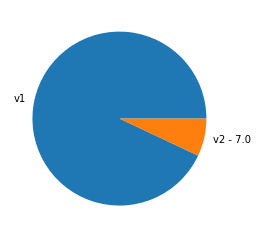

In [351]:
labels = ["v1", "v2 - %.1f" % percentage_v2]
sizes = [int(z) for z in [num_v1s, num_v2s]]
    
plt.pie(sizes, labels=labels)
plt.show()

## Check SEO Test Urls Exist on Production

In [97]:
urls_pass_seo_test = [] #
for url in seo_test_urls:
    html =page_cache.get_html(url, refresh_cache=True)
    if len(html)<2000:
        print("FAIL %s as page looks too small"%url)
    else:
        print("pass %s"%url)

pass https://blog.moneysmart.sg/entertainment/cheap-ktv-singapore-top-picks/
pass https://blog.moneysmart.sg/dining/holland-village-food-price-guide/
pass https://blog.moneysmart.sg/shopping/carousell-lazada-qoo10-shopee-seller/
pass https://blog.moneysmart.sg/healthcare/cheap-dentists-singapore-dental-clinics/
pass https://blog.moneysmart.sg/education/singapore-university-education-cost/
pass https://blog.moneysmart.sg/shopping/amazon-prime-singapore/
pass https://blog.moneysmart.sg/budgeting/iphone-xs-xr-price-singapore/
pass https://blog.moneysmart.sg/budgeting/hair-salon-singapore-guide/
pass https://blog.moneysmart.sg/travel/multi-currency-accounts-youtrip/
pass https://blog.moneysmart.sg/healthcare/health-screening-singapore-cost/
pass https://blog.moneysmart.sg/healthcare/acne-treatment-singapore-cost/
pass https://blog.moneysmart.sg/budgeting/gst-voucher-u-save/
pass https://blog.moneysmart.sg/property/rent-singapore-cost-guide/
pass https://blog.moneysmart.sg/dining/bubble-tea

# Check SEO Test Articles v2 Loads (for before test is setup)

In [99]:
for url in seo_test_urls:
    if test_staging:
        url = make_staging_url(url)
    url = force_url_to_v2(url)
    print("Testing %s" % url)
    if not is_v2_page(url, page_cache):
        print("ERROR: %s isn't v2" %url)
        

Testing https://blog3.mssgdev.com/entertainment/cheap-ktv-singapore-top-picks/?forceTest=test
Testing https://blog3.mssgdev.com/dining/holland-village-food-price-guide/?forceTest=test
Testing https://blog3.mssgdev.com/shopping/carousell-lazada-qoo10-shopee-seller/?forceTest=test
Testing https://blog3.mssgdev.com/healthcare/cheap-dentists-singapore-dental-clinics/?forceTest=test
Testing https://blog3.mssgdev.com/education/singapore-university-education-cost/?forceTest=test
Testing https://blog3.mssgdev.com/shopping/amazon-prime-singapore/?forceTest=test
Testing https://blog3.mssgdev.com/budgeting/iphone-xs-xr-price-singapore/?forceTest=test
Testing https://blog3.mssgdev.com/budgeting/hair-salon-singapore-guide/?forceTest=test
Testing https://blog3.mssgdev.com/travel/multi-currency-accounts-youtrip/?forceTest=test
Testing https://blog3.mssgdev.com/healthcare/health-screening-singapore-cost/?forceTest=test
Testing https://blog3.mssgdev.com/healthcare/acne-treatment-singapore-cost/?forceTe

## Check SEO Test Articles are v2 (for once test is setup)

In [353]:
do_thoroughly = True # does a lot more page requests
repeat_per_url_times = 2
urls_pass_seo_test = [] #
for url in seo_test_urls:
    if test_staging:
        url = make_staging_url(url)
    passes = False
    try:
        if do_thoroughly:
            for a in range(repeat_per_url_times):
                page_cache.get_html(url, refresh_cache=True)
                is_v2 = is_v2_page(url,page_cache)
                if is_v2: 
                    passes=True
                    break
        else:
            passes = is_v2_page(url, page_cache)
    except Exception as e:
        print("%s is TOTAL FAIL with exception %s"%(url, str(e)))
    print("%s %s"%(url, ("pass" if passes else "FAIL")))
    urls_pass_seo_test.append(passes)
    
print("")
print("All pages pass: %s"%str(all(urls_pass_seo_test)))

https://www.moneysmart.tw/articles/各家銀行信用卡免付費客服電話/ pass
https://www.moneysmart.tw/articles/黃金存摺-開戶-銀行/ pass
https://www.moneysmart.tw/articles/如果你是旅遊常客，何不使用雙幣信用卡？/ pass
https://www.moneysmart.tw/articles/line-points-中信-line-pay-聯邦賴點一卡通/ pass
https://www.moneysmart.tw/articles/海外旅遊-現金回饋-信用卡-2019/ pass
https://www.moneysmart.tw/articles/2019年悠遊聯名卡自動加值回饋與相關優惠/ pass
https://www.moneysmart.tw/articles/善用結帳日，額外爽賺利息/ pass
https://www.moneysmart.tw/articles/linepay卡-中國信託-hotelscom/ pass
https://www.moneysmart.tw/articles/燃料費-信用卡/ pass
https://www.moneysmart.tw/articles/2019-電影-信用卡-優惠/ pass
https://www.moneysmart.tw/articles/出國旅遊用現金、信用卡、旅支還是金融卡提款？/ pass
https://www.moneysmart.tw/articles/uupon-20190319-02/ pass
https://www.moneysmart.tw/articles/costco-會員千元年費，商品真的有比較便宜嗎？/ pass
https://www.moneysmart.tw/articles/數位帳戶-王道-richart-大戶-永豐-台新/ pass
https://www.moneysmart.tw/articles/line-pay-回饋-信用卡/ pass
https://www.moneysmart.tw/articles/花旗紅利點數貶值之後，卡友們應該何去何從？/ pass
https://www.moneysmart.tw/articles/

In [354]:
len(non_seo_test_urls)

711

In [358]:
# Lazy copy / paste with a bit of modification

print("Testing a set of urls that aren't in the SEO test point to v1 (at least sometimes)")
approx_num_test_urls = 3
non_seo_test_urls_to_test = [non_seo_test_urls[randint(0, len(non_seo_test_urls))] for z in range(approx_num_test_urls)]
non_seo_test_urls_to_test = non_seo_test_urls[:5] #TODO: REMOVE
do_thoroughly = True # does a lot more page requests
repeat_per_url_times = 2
urls_pass_seo_test = [] #
for url in non_seo_test_urls_to_test:
    if test_staging:
        url = make_stagin_url(url)
    passes = False
    try:
        if do_thoroughly:
            for a in range(repeat_per_url_times):
                page_cache.get_html(url, refresh_cache=True)
                is_v1 = not(is_v2_page(url,page_cache))
                if is_v1: 
                    passes=True
                    break
        else:
            passes = not(is_v2_page(url, page_cache))
    except Exception as e:
        print("%s is TOTAL FAIL with exception %s"%(url, str(e)))
        #raise e
    print("%s %s"%(url, ("pass" if passes else "FAIL")))
    urls_pass_seo_test.append(passes)
    
print("")
print("All pages pass: %s"%str(all(urls_pass_seo_test)))

Testing a set of urls that aren't in the SEO test point to v1 (at least sometimes)
https://www.moneysmart.tw/articles/%e4%ba%ba%e6%b0%91%e5%b9%a3%e5%ae%9a%e5%ad%98-%e5%88%a9%e7%8e%87-%e4%ba%ba%e6%b0%91%e5%b9%a3%e5%ae%9a%e5%ad%98%e5%84%aa%e6%83%a0/ pass
https://www.moneysmart.tw/articles/%e4%ba%9e%e6%b4%b2%e8%90%ac%e9%87%8c%e9%80%9a-%e5%85%ab%e6%9c%88%e9%99%90%e5%ae%9a-%e9%80%b1%e9%80%b1%e9%83%bd%e6%9c%89%e5%93%a9-asiamiles/ pass
https://www.moneysmart.tw/articles/%e7%86%8a%e5%b8%82-%e7%89%9b%e5%b8%82/ pass
https://www.moneysmart.tw/articles/%e9%bb%83%e9%87%91%e6%8a%95%e8%b3%87-4%e6%8c%87%e6%a8%99/ pass
https://www.moneysmart.tw/articles/%e5%a4%96%e5%b9%a3-%e5%8d%97%e9%9d%9e%e5%b9%a3-%e5%ae%9a%e5%ad%98-%e5%88%a9%e7%8e%87-%e5%8c%af%e7%8e%87/ FAIL

All pages pass: False



## Check Test Articles have v2 AMP

In [44]:
if amp_is_enabled[country_to_test]:
    for url in seo_test_urls:

        if test_staging:
            url = make_staging_url(url)
        print("Testing %s"%url)
        amp_url = extract_link_to_amp_version(url, page_cache)
        if not amp_url:
            raise Exception()

        amp_url_is_valid = is_v2_amp_page(amp_url, page_cache)
        if not amp_url_is_valid:
            raise Exception()

        print("Looks good.")
else:
    print("Skipping test as country doesn't have AMP enabled.")

Testing https://www.moneysmart.id/klikbca-gini-lho-cara-cepat-daftar-internet-banking-bca/
Looks good.
Testing https://www.moneysmart.id/klikbca-individual-ini-cara-daftar/
Looks good.
Testing https://www.moneysmart.id/daftar-kode-bank-indonesia-terlengkap-lebih-dari-100-bank/
Looks good.
Testing https://www.moneysmart.id/unipin-voucher-game-online/
Looks good.
Testing https://www.moneysmart.id/djp-online-cara-cepat-bayar-pajak-lapor-spt/
Looks good.
Testing https://www.moneysmart.id/harga-emas-hari-ini/
Looks good.
Testing https://www.moneysmart.id/cara-ambil-antrian-online-bpjs-ketenagakerjaan/
Looks good.
Testing https://www.moneysmart.id/vpn-tarumanagara-cara-log-in-klikbca-bisnis-tanpa-aplikasi/
Looks good.
Testing https://www.moneysmart.id/daftar-internet-banking-bni-gak-ribet-kok-gini-cara-cepatnya/
Looks good.
Testing https://www.moneysmart.id/cara-membuat-npwp-online/
Looks good.
Testing https://www.moneysmart.id/daftar-cimb-clicks-gampang-kok/
Looks good.
Testing https://www.

## Check Canonical Tags

In [100]:
force_canonical_check_to_v2 = True

In [112]:
# site_canonical_url = get_site_canonical_url()
# print("Checking canonical tags against %s"%site_canonical_url)
for url in seo_test_urls + non_seo_test_sample_urls:
    
    if test_staging:
        url = make_staging_url(url)
    #print("Testing %s "% url)
    
    if force_canonical_check_to_v2:
        url = force_url_to_v2(url)
    
    canonical_url = extract_canonical_tag(url, page_cache)
    print("%s \n\thas canonical %s"%(url, canonical_url))
    is_valid, error_message = canonical_tag_is_valid(url, canonical_url)
    
    if not is_valid: 
        #raise Exception()
        print("ERROR: "+ error_message+ "\n")
        
        

https://blog3.mssgdev.com/entertainment/cheap-ktv-singapore-top-picks/?forceTest=test 
	has canonical https://www.mssgdev.com/entertainment/cheap-ktv-singapore-top-picks/
ERROR: Canonical url doesn't appear to point to right site.

https://blog3.mssgdev.com/dining/holland-village-food-price-guide/?forceTest=test 
	has canonical https://www.mssgdev.com/dining/holland-village-food-price-guide/
ERROR: Canonical url doesn't appear to point to right site.

https://blog3.mssgdev.com/shopping/carousell-lazada-qoo10-shopee-seller/?forceTest=test 
	has canonical https://www.mssgdev.com/shopping/carousell-lazada-qoo10-shopee-seller/
ERROR: Canonical url doesn't appear to point to right site.

https://blog3.mssgdev.com/healthcare/cheap-dentists-singapore-dental-clinics/?forceTest=test 
	has canonical https://www.mssgdev.com/healthcare/cheap-dentists-singapore-dental-clinics/
ERROR: Canonical url doesn't appear to point to right site.

https://blog3.mssgdev.com/education/singapore-university-educa

Exception: 

## Check Test Articles and Non-Test Articles Have Sensible Structured Data

I.e.

* Use the canonical url
* Articles have 3 or 4 levels (home page, category, article) in the breadcrumbs
* BlogPosting at least exists

### Check BlogPosting Structured Data

In [115]:
for url in seo_test_urls+ non_seo_test_sample_urls:
    if test_staging:
        url = make_staging_url(url)
        
    url = force_url_to_v2(url)
    print()
    print("Testing %s"%url)
    is_good, error_message = check_blogposting_structured_data_looks_sensible(url, page_cache)
    if not is_good:
        print("ERROR: "+ error_message)
        #raise Exception()


Testing https://blog3.mssgdev.com/entertainment/cheap-ktv-singapore-top-picks/?forceTest=test
getting meta description for https://blog3.mssgdev.com/entertainment/cheap-ktv-singapore-top-picks/?forceTest=test
ERROR: Expected the ID of the blogposting to be the canonical tag https://www.mssgdev.com/entertainment/cheap-ktv-singapore-top-picks/, but got https://blog.mssgdev.com/entertainment/cheap-ktv-singapore-top-picks/.  

Testing https://blog3.mssgdev.com/dining/holland-village-food-price-guide/?forceTest=test
getting meta description for https://blog3.mssgdev.com/dining/holland-village-food-price-guide/?forceTest=test
ERROR: Expected the ID of the blogposting to be the canonical tag https://www.mssgdev.com/dining/holland-village-food-price-guide/, but got https://blog.mssgdev.com/dining/holland-village-food-price-guide/.  

Testing https://blog3.mssgdev.com/shopping/carousell-lazada-qoo10-shopee-seller/?forceTest=test
getting meta description for https://blog3.mssgdev.com/shopping/c

Exception: 

### Check The Breadcrumbs

In [53]:
for url in seo_test_urls + non_seo_test_sample_urls:
    if test_staging:
        url = make_v2_staging_url(url)
    print()
    print("Testing %s"%url)
    is_good, error_message = check_breadcrumbs_are_sensible(url, page_cache)
    if not is_good:
        print("ERROR: "+ error_message)
        #raise Exception()


Testing https://www.moneysmart.id/klikbca-gini-lho-cara-cepat-daftar-internet-banking-bca/

Testing https://www.moneysmart.id/klikbca-individual-ini-cara-daftar/

Testing https://www.moneysmart.id/daftar-kode-bank-indonesia-terlengkap-lebih-dari-100-bank/

Testing https://www.moneysmart.id/unipin-voucher-game-online/

Testing https://www.moneysmart.id/djp-online-cara-cepat-bayar-pajak-lapor-spt/

Testing https://www.moneysmart.id/harga-emas-hari-ini/

Testing https://www.moneysmart.id/cara-ambil-antrian-online-bpjs-ketenagakerjaan/

Testing https://www.moneysmart.id/vpn-tarumanagara-cara-log-in-klikbca-bisnis-tanpa-aplikasi/

Testing https://www.moneysmart.id/daftar-internet-banking-bni-gak-ribet-kok-gini-cara-cepatnya/

Testing https://www.moneysmart.id/cara-membuat-npwp-online/

Testing https://www.moneysmart.id/daftar-cimb-clicks-gampang-kok/

Testing https://www.moneysmart.id/nomor-call-center-bca-yang-bisa-dihubungi/

Testing https://www.moneysmart.id/surat-lamaran-kerja-dan-cara

## Check Cloudflare is (to some extent) Working

In [32]:
# Check that v2 is cached

cache_test_article = force_url_to_v2(non_seo_test_sample_urls[0])
for a in range(3):
    page_cache.get_html(cache_test_article, refresh_cache=True)
is_cached, cache_hit = page_cache.page_was_cdn_cached_and_hit(cache_test_article)
page_load_time = page_cache.page_response_time(cache_test_article)
print("Requested v2 url %s in"%(cache_test_article,))
print("Request took  %.3f"% (page_load_time,))
print("Cached (cloudflare runs) = %s"%is_cached)
print("Cache hit (actually cached) = %s"%cache_hit)

if not cache_hit or page_load_time>0.05:
    print("ERROR: doesn't look properly cached")

Requested v2 url https://blog3.moneysmart.sg/family/cost-raising-5-children/?forceTest=test in
Request took  0.491
Cached (cloudflare runs) = True
Cache hit (actually cached) = False
ERROR: doesn't look properly cached


In [33]:
# Check v1 caching (if SG or HK, not expected to be cached)
cache_test_article = force_url_to_v1(non_seo_test_sample_urls[0])
for a in range(3):
    page_cache.get_html(cache_test_article, refresh_cache=True)
is_cached, cache_hit = page_cache.page_was_cdn_cached_and_hit(cache_test_article)
page_load_time = page_cache.page_response_time(cache_test_article)

    
print("Requested v1 url %s in"%(cache_test_article,))
print("Request took  %.3f"% (page_load_time,))
print("Cached (cloudflare runs) = %s"%is_cached)
print("Cache hit (actually cached) = %s"%cache_hit)
print(country_to_test)
if country_to_test.lower() in ["sg", "hk"]:
    if cache_hit:
        print("ERROR, v1 shouldn't be cached")
    else:
        print("pass")
else:
    if not cache_hit:
        print("ERROR, v2 should be cached")
    elif page_load_time>0.05:
        print("ERROR, page load time was longer than expected for a cache hit")
    else:
        print("pass")
    

Requested v1 url https://blog.moneysmart.sg/family/cost-raising-5-children/?forceTest=control in
Request took  0.044
Cached (cloudflare runs) = True
Cache hit (actually cached) = False
sg
pass


## Check That Article Redirects are Working

In [372]:
#TODO: ideally check the redirect status, but not really sure how to do this nicely (it is in request.history)

In [62]:
redirects = load_redirects(country_to_test, for_staging = test_staging)

cow
Loading all of the redirects from ./Redirects/id-production-redirects.csv
Skipping first line of url file: ['Origin', 'Target', 'Type', 'Format']
Loaded 131 redirects


### Redirects on v1

In [63]:
for from_url, to_url, status_code in redirects:
    from_url = force_url_to_v1(from_url)
    try:
        
        html = page_cache.get_html(from_url)
    except:
        html = ""
    if len(html)<2000:
        print("\nFAIL %s \n"% from_url)
    else:
        print("pass %s", from_url)


FAIL https://www.moneysmart.id/banner_ad/mitsubishi-top-mobile/?forceTest=control 

pass %s https://www.moneysmart.id/5-orang-terkenal-ini-sukses-walau-dulu-dipandang-sebelah-mata/?forceTest=control
pass %s https://www.moneysmart.id/bisnis-otomotif-di-lapangan-hijau/?forceTest=control
pass %s https://www.moneysmart.id/5-smartphone-yang-mengguncang-diawal-2014/?forceTest=control
pass %s https://www.moneysmart.id/gaji-pertama-para-first-jobber-2/?forceTest=control
pass %s https://www.moneysmart.id/biaya-mudik-di-akhir-tahun/?forceTest=control
pass %s https://www.moneysmart.id/merencanakan-masa-pensiun/?forceTest=control
pass %s https://www.moneysmart.id/ini-lho-cara-cepat-bayar-pajak-dan-lapor-spt-dengan-djp-online/?forceTest=control
pass %s https://www.moneysmart.id/mau-kredit-pahami-skor-kredit-anda/?forceTest=control
pass %s https://www.moneysmart.id/kredit-spesial-dihari-istimewa/?forceTest=control
pass %s https://www.moneysmart.id/mengenal-bilyet-giro-manfaat-dan-cara-mencairkannya

### Redirects on v2

In [382]:
#Simple test based on if the page loads and there's some sensible html length
#TODO: actually check destination page
for from_url, to_url, status_code in redirects:
    from_url = force_url_to_v2(from_url)
    try:
        
        html = page_cache.get_html(from_url)
    except:
        html = ""
    if len(html)<2000:
        print("\nFAIL %s \n"% from_url)
    else:
        print("pass %s", from_url)


FAIL https://www3.moneysmart.tw/articles/%e5%b0%8f%e8%b3%87%e8%87%aa%e5%8a%a9%e7%8e%a9%e6%97%a5%e6%9c%ac-%e6%9d%b1%e4%ba%ac%e7%9c%81%e9%8c%a2%e5%85%a8%e6%94%bb%e7%95%a5/?forceTest=test 


FAIL https://www3.moneysmart.tw/articles/%e7%a4%be%e6%9c%83%e6%96%b0%e9%ae%ae%e4%ba%ba%e7%9a%84%e7%ac%ac%e4%b8%80%e5%bc%b5%e4%bf%a1%e7%94%a8%e5%8d%a1%e8%a9%b2%e5%a6%82%e4%bd%95%e9%81%b8%e6%93%87%ef%bc%9f/?forceTest=test 


FAIL https://www3.moneysmart.tw/articles/%e6%9d%b1%e5%8d%97%e4%ba%9e%e6%97%85%e9%81%8a%e5%bf%85%e7%9c%8b%ef%bc%81-6-%e5%a4%a7%e5%b8%b8%e8%a6%8b%e9%a8%99%e9%8c%a2%e6%89%8b%e6%b3%95%e8%a6%81%e5%b0%8f%e5%bf%83/?forceTest=test 


FAIL https://www3.moneysmart.tw/articles/%e5%84%b2%e8%93%84%e6%96%b0%e6%89%8b-%e5%ad%98%e9%8c%a2-%e7%ac%ac%e4%b8%80%e6%a1%b6%e9%87%91/?forceTest=test 


FAIL https://www3.moneysmart.tw/articles/2020-%e8%ab%8b%e5%81%87%e6%94%bb%e7%95%a5-%e6%97%85%e9%81%8a%e6%87%b6%e4%ba%ba%e5%8c%85-%e7%8e%a9%e5%93%a9%e7%a8%8b/?forceTest=test 


FAIL https://www3.moneysmart.tw/a

# Check RSS Feeds

## Check the core RSS feed

In [ ]:
urllib.parse.urljoin

In [68]:
core_rss_url = urllib.parse.urljoin(get_site_canonical_url(), "/feed/")
core_rss_body = page_cache.get_html(core_rss_url)
if "xml" in core_rss_body:
    print("Basic RSS feed looks good")
else:
    print("FAIL: RSS feed at %s doesn't look good"%core_rss_url)

Basic RSS feed looks good


In [69]:
if "www3" in core_rss_body:
    print("ERROR: www3 in rss feed")
    
if "admin." in core_rss_body or "blog-admin." in core_rss_body:
    print("ERROR: looks like an admin url in the rss feed somewhere.")

## Check the Full List of RSS feed (a lot of requests)

In [70]:
def load_rss_feed_urls_from_scalyr_logs(scalyr_log_file_path):
    """
    Expects a file as per the result of https://www.scalyr.com/events?filter=%22%2Ffeed%2F%22%20$status%3D200&teamToken=RsXhT5US%2FMZ7ugkOhT2g3g--&logSource=*blog-moneysmart-sg-*&showSystemPrefs=%5B%22timestamp%22%5D&showAdditionalFields=%5B%22uri%22,%22remote_ip%22,%22status%22%5D&startTime=7%20days&displayMode=%5Bobject%20Object%5D
    i.e. lines like:  00:18:12.000 uri='/comments/feed/' remote_ip='62.210.215.109' status=200
    
    Returns localised to staging / production
    """
    base_url = get_site_canonical_url()
    with open(scalyr_log_file_path) as f:
        lines = f.readlines()
        print("%i lines"%len(lines))
        urls = [z.split(" uri=")[1].split(" ")[0].strip("'") for z in lines]
        urls_filtered = [z for z in urls if "/feed/" in z]
    
    distinct_urls = list(set(urls_filtered))
    distinct_urls.sort()
    full_distinct_urls = [urllib.parse.urljoin(base_url, z) for z in distinct_urls]
    return full_distinct_urls

In [71]:
rss_log_urls = rss_feed_scalyr_requests_raw[country_to_test]
rss_urls = load_rss_feed_urls_from_scalyr_logs(rss_log_urls)
print("found %i RSS feed urls "% len(rss_urls))
print("e.g. (first 10):")
for a in rss_urls[:10]:
    print(a)

10000 lines
found 4516 RSS feed urls 
e.g. (first 10):
https://www.moneysmart.id/10-bisnis-raffi-ahmad-dan-nagita-slavina-bikin-makin-tajir/feed/
https://www.moneysmart.id/10-kegiatan-produktif-saat-weekend-tanpa-bikin-jakarta-macet-lagi/feed/
https://www.moneysmart.id/10-kiat-mencapai-kebebasan-finansial-ala-robert-kiyosaki/feed/
https://www.moneysmart.id/10-peluang-bisnis-paling-menguntungkan-selama-ramadan/feed/
https://www.moneysmart.id/10-quotes-susi-pudjiastuti-yang-bisa-jadi-motivasi-sukses/feed/
https://www.moneysmart.id/10-reksadana-saham-terbaik-2017-return-sampai-28/feed/
https://www.moneysmart.id/12-tempat-wisata-gratis-buat-tahun-baru-bali-jakarta-surabaya/feed/
https://www.moneysmart.id/15-meme-asuransi-kocak-menusuk-banget/feed/
https://www.moneysmart.id/21-tempat-bermain-anak-di-jakarta-yang-patut-dikunjungi/feed/
https://www.moneysmart.id/28375-2/feed/


In [72]:
passing_rss_feeds = []
failing_rss_feeds = []

In [73]:
num_rss_urls_to_check = 200 # put -1 for all 

print("Checking the first %i of the rss feed urls"%num_rss_urls_to_check)
num_rss_urls = len(rss_urls)
for i, rss_url in enumerate(rss_urls[:num_rss_urls_to_check]):
    if i<10:
        print("checking %i %s"%(i, rss_url))
    if i%10==0:
        print("Checking %i / %i"%(i, num_rss_urls))
    try:
        rss_text = page_cache.get_html(rss_url)
        if "xml" in rss_text:
            passing_rss_feeds.append(rss_url)
        else:
            failing_rss_feeds.append(rss_url)
    except:
        failing_rss_feeds.append(rss_url)
        
print("Got %i passing and %i failing RSS feeds"%(len(passing_rss_feeds), len(failing_rss_feeds)))

Checking the first 200 of the rss feed urls
checking 0 https://www.moneysmart.id/10-bisnis-raffi-ahmad-dan-nagita-slavina-bikin-makin-tajir/feed/
Checking 0 / 4516
checking 1 https://www.moneysmart.id/10-kegiatan-produktif-saat-weekend-tanpa-bikin-jakarta-macet-lagi/feed/
checking 2 https://www.moneysmart.id/10-kiat-mencapai-kebebasan-finansial-ala-robert-kiyosaki/feed/
checking 3 https://www.moneysmart.id/10-peluang-bisnis-paling-menguntungkan-selama-ramadan/feed/
checking 4 https://www.moneysmart.id/10-quotes-susi-pudjiastuti-yang-bisa-jadi-motivasi-sukses/feed/
checking 5 https://www.moneysmart.id/10-reksadana-saham-terbaik-2017-return-sampai-28/feed/
checking 6 https://www.moneysmart.id/12-tempat-wisata-gratis-buat-tahun-baru-bali-jakarta-surabaya/feed/
checking 7 https://www.moneysmart.id/15-meme-asuransi-kocak-menusuk-banget/feed/
checking 8 https://www.moneysmart.id/21-tempat-bermain-anak-di-jakarta-yang-patut-dikunjungi/feed/
checking 9 https://www.moneysmart.id/28375-2/feed/
C

In [75]:
if len(failing_rss_feeds)>0:
    failing_rss_feeds_to_focus = [z for z in failing_rss_feeds if urllib.parse.urlsplit(z).path.startswith("/feed")]
    print("First 20 urls to focus on:")
    for a in failing_rss_feeds_to_focus[:20]:
        print(a)
    print("")
    print("First 20 failing rss urls overall:")
    for a in failing_rss_feeds[:20]:
        print(a)

First 20 urls to focus on:

First 20 failing rss urls overall:
https://www.moneysmart.id/apa-itu-dropship-belajar-cara-mendulang-uang-skema-bisnis/feed/
https://www.moneysmart.id/cara-mengelola-uang-untuk-investasi-buat-yang-punya-gaji-atau-sekedar-penghasilan-sampingan/feed/
